In [1]:
using DifferentialEquations, DiffEqFlux, OrdinaryDiffEq, Flux, Optim, Plots

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative /home/nadanai/.julia/packages/CUDAnative/C91oY/src/compatibility.jl:176


Consider the following ODE system:
\begin{align}
\dot{u}_1 &= -0.1 u_1^3 - 2.0 u_2^3 \\
\dot{u}_2 &= 2.0 u_1^3 - 0.1 u_2^3
\end{align}

i.e.
\begin{equation}
\begin{pmatrix}
\dot{u}_1 \\ \dot{u}_2
\end{pmatrix}=
\begin{pmatrix}
-0.1 & -2.0 \\
2.0 & -0.1
\end{pmatrix}
\begin{pmatrix}
u_1^3 \\ u_2^3
\end{pmatrix}
\end{equation}

In [2]:
# The ODE system can be represented by the following function
function trueODEfunc(du,u,p,t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

# All numbers in Float32 for ML optimizers
u0 = Float32[2.0,1.0]
tspan = (0.0f0,1.5f0)
N = 30
tsteps = range(tspan[1],tspan[2],length=N)

p = [1.5,1.0,3.0,1.0]
prob_trueode = ODEProblem(trueODEfunc,u0,tspan)
data_trueode = Array(solve(prob_trueode,Tsit5(),saveat=tsteps)); 
plot(data_trueode')

Assume we know there's a cubic function involved. What are the coefficients? Let's build a neural network which takes the u^3s as input:

\begin{equation}
\begin{pmatrix}
\dot{u}_1 \\ \dot{u}_2
\end{pmatrix}=
NN
\begin{pmatrix}
u_1^3 \\ u_2^3
\end{pmatrix}
\end{equation}

In [4]:
dudt2 = FastChain((x,p) -> x.^3, # Take x^3 as input
        FastDense(2,50,tanh),
        FastDense(50,2))
neural_ode_f(u,p,t) = dudt2(u,p) # Our new derivative function is this NN

# The point of this is to show that theneural network 
# can be connected directly into the ODE solver as the
# new gradient function

pinit = initial_params(dudt2) # Completely random NN parameters
prob = ODEProblem(neural_ode_f,u0,tspan,pinit)
sol = solve(prob,saveat=tsteps);

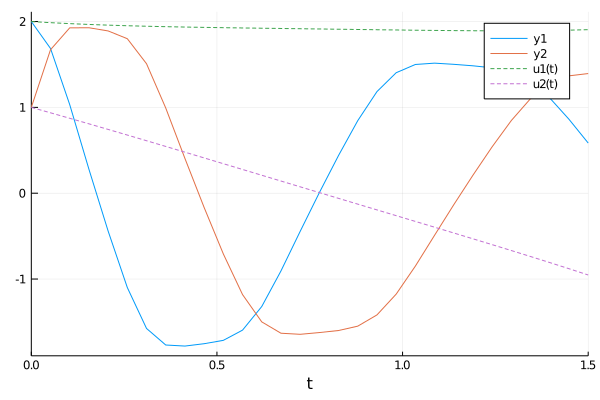

In [5]:
# This is the solution to our NN-ODE or neural ODE, with random parameters
plot(tsteps,data_trueode')
plot!(sol,ls=:dash)
# As you can see, there is no fit yet

loss: 0.867: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Info: Saved animation to 
│   fn = /run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/notebooks/fit_NNODE.gif
└ @ Plots /home/nadanai/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/notebooks/fit_NNODE.gif")
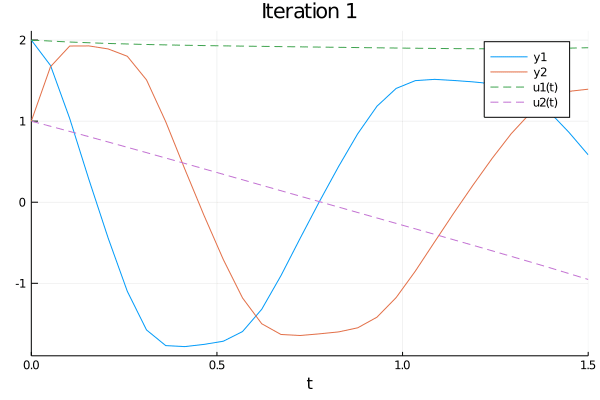

In [10]:
# To fit, as before, make a loss function and call an optimizer

function loss(p)
    mod_prob = remake(prob,p=p)
    mod_sol = solve(mod_prob,Tsit5(),saveat=tsteps)
    sum(abs2,Array(mod_sol)-data_trueode)
end

# Save training into gif animation (turn off to speed up)

frames = []
function save_callback(p,l)
    mod_prob = remake(prob,p=p)
    mod_sol = solve(mod_prob, saveat=0.1)
    push!(frames,mod_sol)
    false
end

# Now train 
# Local optimizers such as ADAM are not good at finishing
# So swap to global BFGS for second phase of training

res1 = DiffEqFlux.sciml_train(loss,pinit,ADAM(0.05),cb=save_callback,maxiters=200)
res2 = DiffEqFlux.sciml_train(loss,res1.minimizer,BFGS(initial_stepnorm=0.01),cb=save_callback)

# Look at animation
anim = @animate for i in 1:length(frames)
    plot(sol.t,data_trueode')
    plot!(frames[i], title="Iteration $i",ls=:dash)
end

gif(anim,"fit_NNODE.gif",fps=15)

# All we've done here is used the NN to make nonlinear combinations of 
# the input u^3 terms. The problem with this is that the NN is generally
# non-interpretable, is prone to overfitting, and extrapolates poorly. 
# What we would like to do is convert the NN back into algebraic form. 